<a target="_blank" href="https://colab.research.google.com/github/GP115/Labs/blob/main/notebooks/pulse_assignment_8.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# ***Assignment 8: Taking the Pulse of Global Groundwater***

This assignment was developed by Sasha Richey McLarty (sasha.richey@wsu.ed), Washington State University & Michael Morphew (mmorphew@stanford.edu), Stanford Environmental Geophysics Group

This assignment is due on Tuesday 2024-2-27, before class. Change the name of your notebook to tpp_assignment_7_sunetID.ipynb Share your completed notebook with the TAs akroo@stanford.edu & flora221@stanford.edu using the share banner at the top. For help submitting, see the canvas walkthrough. If you are still having technical difficulties, email us before the deadline.


###**INTRODUCTION TO THE ASSIGNMENT**
This week we will observe changes in the volume of stored groundwater at a global level. We will work with GRACE data while also leveraging additional datasets and model outputs. Students will select an area of interest and consider the strengths and limitations of remotely sensed observations at large spatial scales.

###**DATA SETS**
Data sets used in this assignment are: 1) total water storage anomalies; 2) model output of SWE, soil moisture, canopy water; 3) population density; 4) irrigation density.

**Resolution**

All datasets have a spatial resolution of 1 degree latitude by 1 degree longitude. All datasets exception irrigation and population density have monthly sampling from 2003-2016. Irrigation and population density are "snapshots" from 2010.

**Units:**

Total Water Storage Anomaly: $[cm]$ (of water)

Model outputs of SWE, soil moisture, and canopy water: $[mm]$

Population density: estimated number of persons per square kilometer

Irrigation density: a number corresponding to land use type: 0=non-cropland, 1=major irrigation, 2=minor irrigation, 3-8=rainfed

We will also reference our temperature and precipitation dataset analysis from Assignment 2.

NOTE - working with the model outputs - You will need to combine the model outputs with total change in water storage. Given that 1 cm = 10 mm, you must divide the model outputs by 10 (or multiply the total water storage change by 10) before combining.


###**TOOLBOX**

All the Python functions and packages you will use in this assignment are in the toolbox for the course. We add new tools to the toolbox with each assignment as new ways of analyzing and visualizing data are introduced.
https://colab.research.google.com/drive/1gQxlpnogdJzykfNqjIGO4VLMnHHhrvcC?usp=sharing

##**THE LEARNING GOALS FOR THE WEEK**

(where the course learning goals are in plain text, and the focus this week is in italics)

● learn about the ways in which climate change and human activity are impacting planet Earth, *with a focus this week groundwater from a global perspective.*

● become familiar with the wide range of sensors available to study various components of the Earth system. These include sensors on satellites, aircraft, ground-based platforms, and deployed above or beneath the surface on land or water. *This week we will work with data acquired using the GRACE satellite system.*

● become familiar with the basic physical principles (resolution, sampling, processing workflows, etc.) common to all sensors, *working this week with data sets all of which differ in terms of resolution, sampling, and processing workflows.*

● work with various sources of data, learning how to access, analyze, synthesize, and describe the data to quantify trends; think critically and creatively about how to project these trends into the future. *This week we will consider trends in the data that reveal periods of hydrologic extremes, evaluate the dominant drivers of observed data, compare the data in different geographic regions, and determine causal links between various data sets.*

● describe the complex interactions between human activity and various components of the Earth system. This week we begin by looking at global water budget dynamics to consider how humans add an additional layer of change on top of natural processes, both for the total water budget and groundwater. *In this assignment we will consider how the drivers of observed change may impact the future.*

● become motivated to think about new sensors and new ways of using sensor data to study the planet.

# **Assignment**

### 1) **Install and Import Packages**


In [ ]:
!pip install xarray numpy pandas geopandas cartopy ipywidgets rioxarray pykrige&> /dev/null
!pip install shapely --no-binary shapely &> /dev/null

In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cf
import datetime
from ipywidgets import widgets, interact
from shapely.geometry import mapping
from matplotlib.colors import LogNorm
matplotlib.rcParams['font.size'] = 14
import shapely
from pykrige.ok import OrdinaryKriging

In [ ]:
!git clone https://premonition.stanford.edu/mmorphew/taking-the-pulse-global-data.git

Cloning into 'taking-the-pulse-global-data'...
remote: Enumerating objects: 29, done.
remote: Total 29 (delta 0), reused 0 (delta 0), pack-reused 29
Receiving objects: 100% (29/29), 249.26 MiB | 9.12 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (14/14), done.


In [ ]:
total_water_storage_data = xr.load_dataset('taking-the-pulse-global-data/twsa.nc')
total_water_storage_data = total_water_storage_data.transpose("time", "y", "x")
total_water_storage_data

<xarray.Dataset>
Dimensions:  (y: 180, x: 360, time: 168)
Coordinates:
  * y        (y) int64 -90 -89 -88 -87 -86 -85 -84 -83 ... 83 84 85 86 87 88 89
  * x        (x) int64 -180 -179 -178 -177 -176 -175 ... 174 175 176 177 178 179
  * time     (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2016-12-01
Data variables:
    TWSA     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan

# Part 1: GRACE Total Water Storage Anomalies

The Gravity Recovery and Climate Experiment (GRACE) satellite mission is a joint mission between the German Space Agency and the U.S. National Aeronautics and Space Agency (NASA). Originally launched to better understand Earth’s gravity field, GRACE has since been used to study a myriad of additional Earth system variables including oceanic currents, sea level rise, and, as you will study in this assignment, groundwater. GRACE is a relative gravimeter; therefore it can only observe relative changes in gravity between two time periods or locations and does not observe the total magnitude of the gravity field.

Gravity anomalies are converted into water mass anomalies to study the hydrologic cycle. GRACE applications to the hydrologic cycle are based on the simple water budget (covered in class), which represents changes in total water storage as the sum of changes in the component parts of the water budget. GRACE provides an integrated measure of the total vertical water column over large areas, but the GRACE observations cannot directly differentiate between mass changes in any particular variable.

The GRACE-based water budget represents anomalies in total water storage, S, as the sum of anomalies in various components (Equation 1). To determine the groundwater anomaly, we need to solve for $∆GW$ in this equation.


### Equation 1
$∆S=∆SW+∆SWE+∆SM+∆C+∆GW$

$∆$ = anomaly in a variable

$∆S$ = total water storage anomaly [L]

$∆SW$ = surface water anomaly  [L]

$∆SWE$ = snow water equivalent anomaly  [L]

$∆SM$= soil moisture anomaly  [L]

$∆C$= canopy anomaly  [L]

$∆GW$ = groundwater anomaly


## Q1-a: Global Trend Map for Total Water Storage Anomaly
Produce a globally gridded map of the trend in total water storage anomalies for the recent period (2003-2016). Begin by calculating the mean in each grid cell and subtract that mean from each month’s value per grid cell to produce anomalies. Take a look at the toolbox for this!
Calculate the trend in each grid cell. The units of the anomalies are mm and the units of the trend is mm/yr. Comment on similarities and differences between this map and the trend maps for precipitation you did in assignment 4.



##Q1-b: Basin Averages for GRACE

We have provided a map of the major groundwater basins in the world. The code below gives you access to the shape information for these basins so that you can extract basin-wide information. Select one basin to be your region of interest for this assignment. **Whenever this assignment asks you to make regional maps or regional calculations, we are referring to this basin that you have selected**.


For your selected basin, calculate a basin-average of the GRACE TWS anomalies. Plot the time series and calculate the 1D trend (not a trend map!) of the basin-average and comment on what you see.


A cleaner image of the basin map produced in the code below may be found here, as an aid in selecting your basin:
https://www.cbc.ca/polopoly_fs/1.3117673.1434572717!/fileImage/httpImage/aquifer-depletion.jpg

**Be patient with the link, it will take a second to load.**

In [ ]:
# No need to edit! Just run this :)
world_aquifers = gpd.read_file('taking-the-pulse-global-data/world_aquifer_systems_nocoast/world_aquifer_systems_nocoast.shp')

One practical part of data science is updating any missing parts of the data. Here I have updated the NaN entries with their proper basin name.

In [ ]:
# No need to edit! Just run this :)
world_aquifers['Aquifer_sy']
world_aquifers.at[3,'Aquifer_sy'] = 'Cambro-Ordovician Aquifer System'
world_aquifers.at[35, 'Aquifer_sy'] = 'Northern Great Plains Aquifer'
world_aquifers.at[17, 'Aquifer_sy'] = 'Upper Kalahari-Cuvelai-Upper Zambezi Basin'
world_aquifers.at[18, 'Aquifer_sy'] = 'Lower Kalahri-Stampriest Basin'
world_aquifers.at[14, 'Aquifer_sy'] = 'Sudd Basin (Umm Ruwaba Aquifer)'

In [ ]:
# No need to edit! Just run this :)
world_aquifers['coords'] = world_aquifers['geometry'].apply(lambda x: x.representative_point().coords[:])
world_aquifers['coords'] = [coords[0] for coords in world_aquifers['coords']]

In [ ]:
# No need to edit! Just run this :)
world_aquifers['Aquifer_sy']

0     Guarani Aquifer System (Parana&Choco Parana Ba...
1                                        Maranhao Basin
2              Atlantic and Gulf Coastal Plain Aquifers
3                      Cambro-Ordovician Aquifer System
4                California Cenral Vally Aquifer System
5                                         Canning Basin
6                                  Great Artesian Basin
7     Nubian Aqufer System (Nubian Sandstone and Pos...
8                           Sahara Septentrional (SASS)
9                                    Murzuk-Djado Basin
10                            Taoudeni-Tanezrouft Basin
11                          Bassin Sénégalo-Mauritanien
12                    Iullemeden-Irhazer Aquifer System
13                                  Bassin du lac Tchad
14                      Sudd Basin (Umm Ruwaba Aquifer)
15                                    Ogaden-juba Basin
16                                      Bassin du Congo
17           Upper Kalahari-Cuvelai-Upper Zambez

Below, write the name of the basin you wish to study in more detail.

In [ ]:
# Remember to spell it exactly as it was written -- use copy paste!
my_aquifer_name = 'Tunguss Basin'
my_aquifer = world_aquifers[world_aquifers['Aquifer_sy']==my_aquifer_name]
my_aquifer

,OBJECTID,AREA,PERIMETER,WROB0_CONT,WROB0_CO_1,HYGEO,Aquifer_sy,Shape_Leng,Shape_Area,geometry,coords
23,3676,1.047059e+14,2.062106e+08,158,0,26,Tunguss Basin,65.460579,223.19183,"POLYGON ((91.43304 67.57074, 91.84391 67.90138...","(101.29703529854936, 63.884117145500056)"


In [ ]:
# No need to edit! Just run this :)
total_water_storage_anomaly_copy = xr.load_dataset('taking-the-pulse-global-data/twsa.nc')
total_water_storage_anomaly_copy.rio.write_crs(4326, inplace=True)

<xarray.Dataset>
Dimensions:      (y: 180, x: 360, time: 168)
Coordinates:
  * y            (y) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * x            (x) int64 -180 -179 -178 -177 -176 -175 ... 175 176 177 178 179
  * time         (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2016-12-01
    spatial_ref  int64 0
Data variables:
    TWSA         (y, x, time) float64 nan nan nan nan nan ... nan nan nan nan

This generates a spatial distribution:

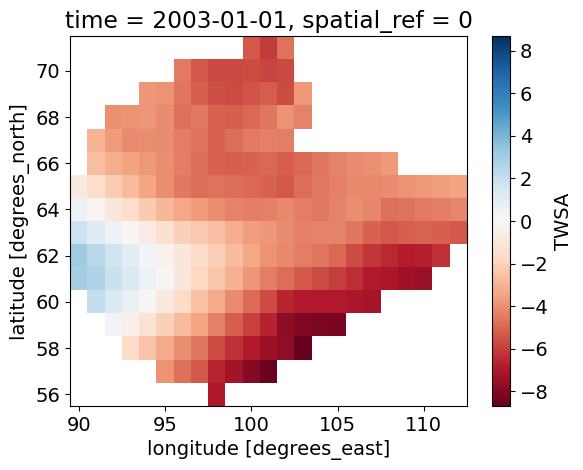

In [ ]:
# No need to edit! Just run this :)
total_water_storage_anomaly_copy.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
total_water_storage_anomaly_clipped = total_water_storage_anomaly_copy.rio.clip(my_aquifer.geometry.apply(mapping), my_aquifer.crs, drop=True)
total_water_storage_anomaly_clipped['TWSA'].isel(time=0).plot(cmap='RdBu')

Generate a temporal distribution:

# Part 2: GRACE-Derived Maps of Groundwater Anomalies

GRACE has revolutionized the study of large-scale groundwater dynamics by allowing for an integrated picture of groundwater changes that do not rely on sparse ground-based observation networks. However, as with any tool, the use of GRACE to study groundwater needs to be carefully considered. GRACE is used to estimate ∆S in Equation 1. In order to get $∆GW$ which is what we want, we are going to use model outputs for the remaining components. You’ll be asked to think about how additional datasets could be useful in improving estimates of $∆GW$.





##Q 2-a: Global Changes in Groundwater Storage
We are going to use the Global Land Data Assimilation System (GLDAS), a NASA modeling framework to get three of the values we need in Equation 1: soil moisture $∆SM$, snow water equivalent $∆SWE$, and canopy water $∆C$. In this assignment, we do not have a way of getting information about anomalies in the water stored as surface water - $∆SW$. Document if there are large surface water features in your study area (such as lakes, reservoirs, or glaciers) that are not accounted for and comment on how these features will impact your results.


Recall that GLDAS model outputs are in mm and $∆S$ from GRACE is in cm.

In [ ]:
### No need to edit this code block -- simply reading in data
gldas_snow_water_equivalent = xr.load_dataset('taking-the-pulse-global-data/SWE.nc')
gldas_snow_water_equivalent = gldas_snow_water_equivalent.transpose("time", "y", "x")

gldas_canopy_water = xr.load_dataset('taking-the-pulse-global-data/can.nc')
gldas_canopy_water = gldas_canopy_water.transpose("time", "y", "x")

gldas_soil_moisture = xr.load_dataset('taking-the-pulse-global-data/sm.nc')
gldas_soil_moisture = gldas_soil_moisture.transpose("time", "y", "x")

**Your Answer Here (1-2 Sentences)**

## Q 2-b: Basin-averaged time series

Produce a basin-averaged time series and trend of $∆GW$ for your focus region. Compare and contrast the trends and time series for $∆GW$  and $∆S$.

Also plot the other individual components for your region (soil moisture $∆SM$, snow water equivalent $∆SWE$, canopy water $∆C$). Of the water budget components on the right hand side of Equation 1, which component(s) is dominating the total GRACE signal?

In [ ]:
# complete your anomaly calculation here
# store in in a variable called groundwater, then run the cell below


In [ ]:
# no need to edit this cell, just run and continue!
groundwater = groundwater.to_dataset(name='groundwater_anomaly')
groundwater

In [ ]:
# begin plotting here


## Q 2-c: Groundwater in your study area
Conduct a short search about groundwater in your study area. Describe the large aquifer system you chose: briefly describe the system (3-4 sentences) and comment on how well the GRACE-derived information about anomlies in groundwater storage is likely to represent what is happening in the aquifer in your study area.



**Your Answer Here (3-4 Sentences)**

## Q 2-d: Comparing Groundwater with Population and Irrigation Density
Plot the population density and irrigation extent maps. Based on these maps, and additional information as needed, what do you think is driving the total water storage and groundwater patterns observed in the previous two questions? What implications exist for the future state of groundwater and total water availability based on your attribution of change?

In [ ]:
# No need to edit! Just run this :)
# Read in additional population and irrigation information
population_density = xr.load_dataset('taking-the-pulse-global-data/population_density.nc')
population_density=population_density.sel(time='2010-01-01', method='nearest')
irrigation_density = xr.load_dataset('taking-the-pulse-global-data/irrigation_density.nc')
irrigation_density = irrigation_density.isel(time=0)

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/usr/local/lib/python3.10/dist-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/usr/local/lib/python3.10/dist-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


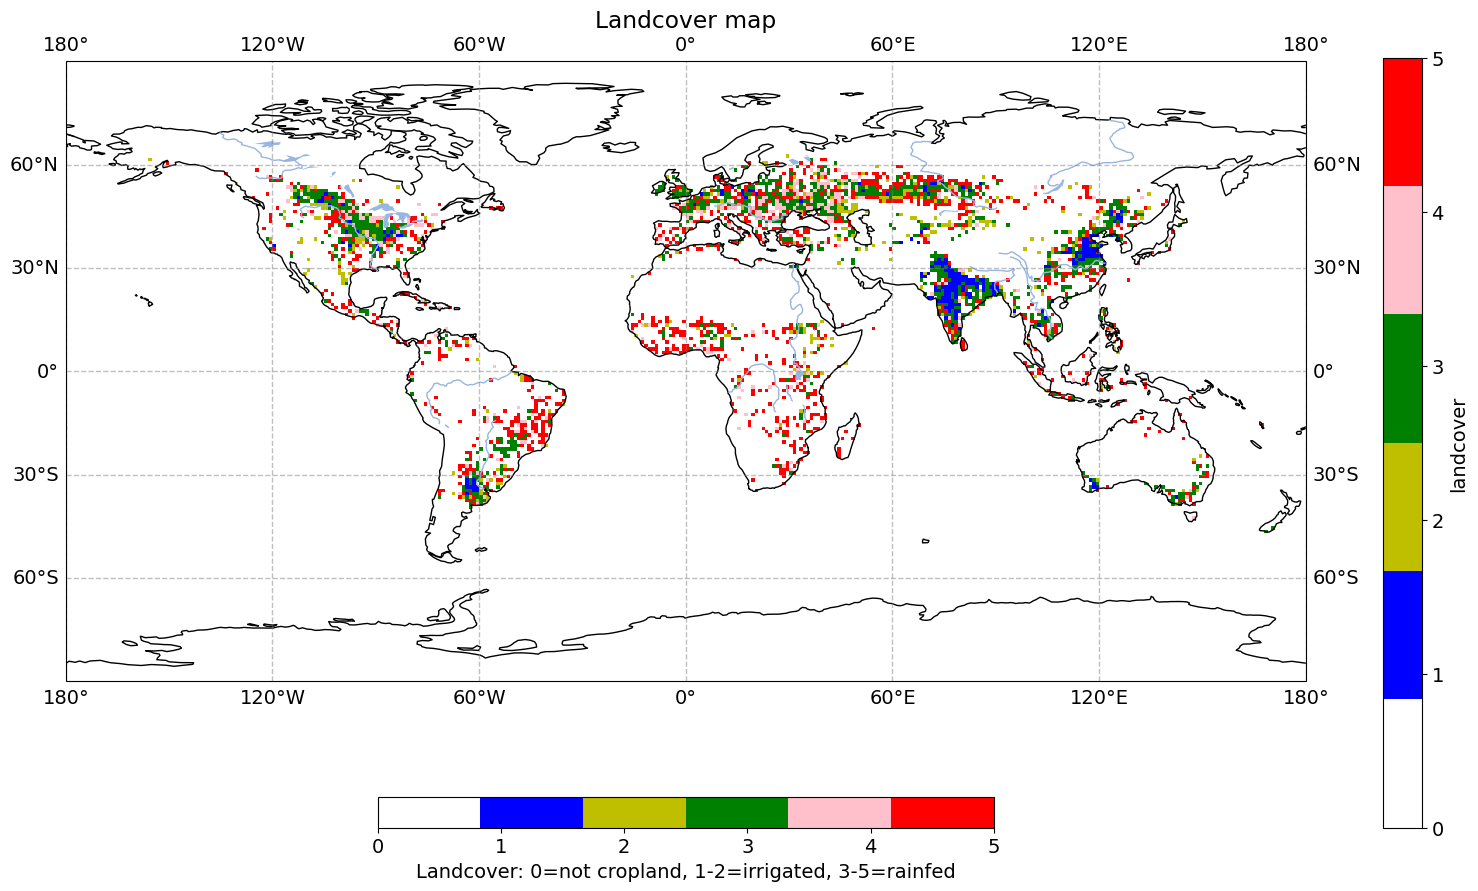

In [ ]:
# No need to edit! Just run this :)
discrete_cmap = matplotlib.colors.ListedColormap(['white','b','y','g','pink', 'r'])

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.axes.add_feature(cf.COASTLINE, color='k')
ax.axes.add_feature(cf.LAKES)
ax.axes.add_feature(cf.RIVERS)

out = irrigation_density['landcover'].plot(ax=ax, cmap=discrete_cmap)
#my_aquifer.boundary.plot(ax=ax, color='red')
cb = plt.colorbar(out, fraction=0.04, orientation='horizontal')
cb.set_label("Landcover: 0=not cropland, 1-2=irrigated, 3-5=rainfed")
ax.set_aspect(1)
ax.set_title("Landcover map")
ax.set_facecolor('lightblue')
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    color='gray',
    alpha=0.5,
    linestyle='--'
)

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/usr/local/lib/python3.10/dist-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/usr/local/lib/python3.10/dist-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


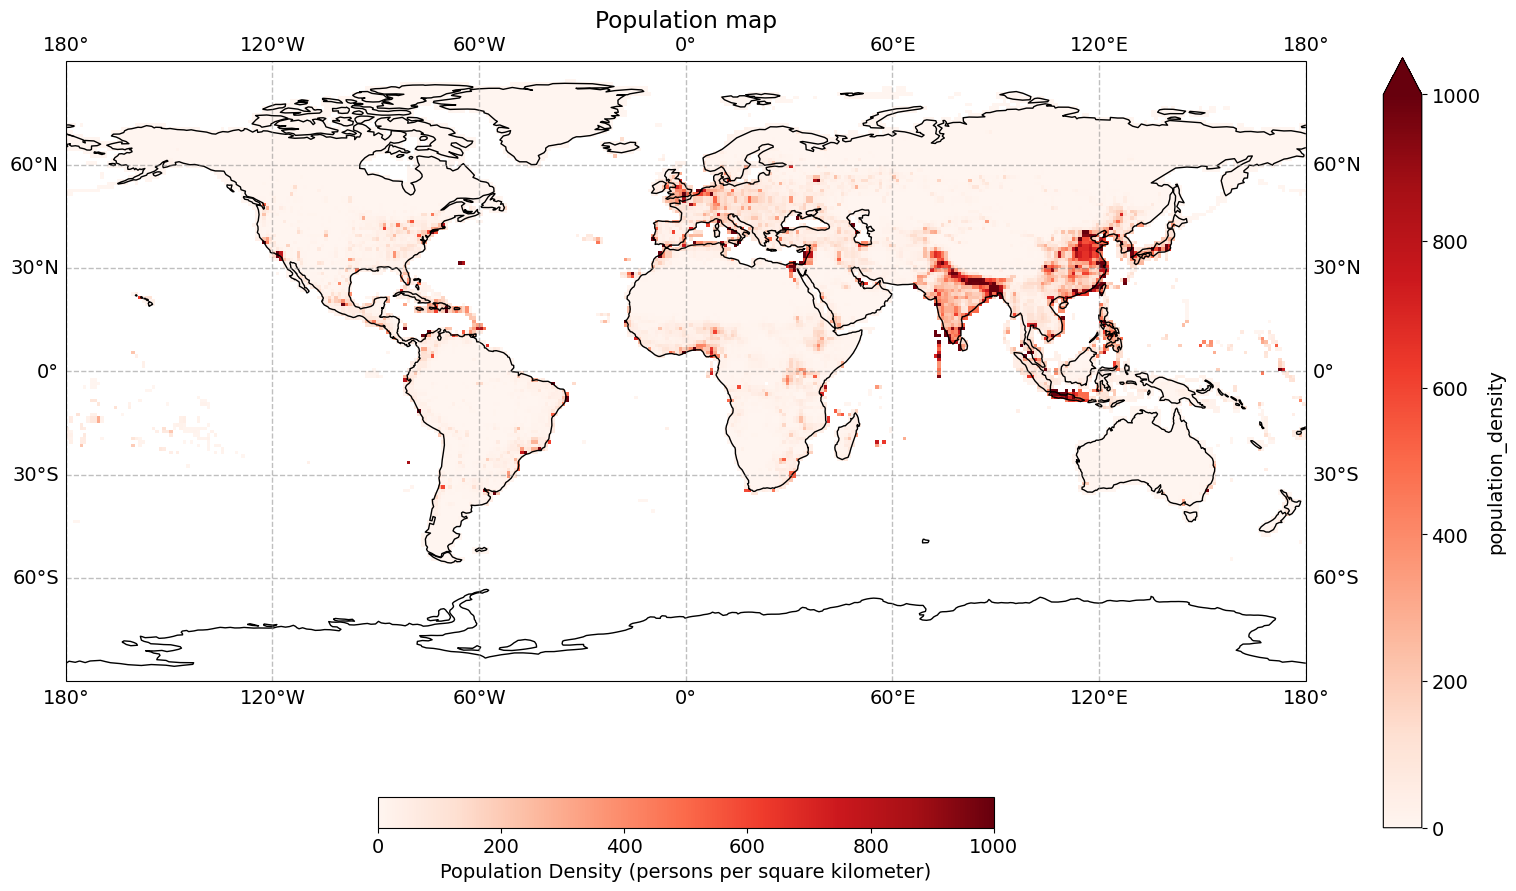

In [ ]:
# No need to edit! Just run this :)

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.axes.add_feature(cf.COASTLINE, color='k')

out = population_density['population_density'].plot(cmap='Reds', ax=ax, vmin=0, vmax=1000)
#my_aquifer.boundary.plot(ax=ax, color='red')
cb = plt.colorbar(out, fraction=0.04, orientation='horizontal')
cb.set_label("Population Density (persons per square kilometer)")
ax.set_aspect(1)
ax.set_title("Population map")

gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    color='gray',
    alpha=0.5,
    linestyle='--'
)

**Your Answer Here (3-4 Sentences)**

# Q3: Taking the Pulse in the Future

In this assignment, we worked with what we have in terms of sensors and data analysis workflows. If you were given $1 million to develop a new form of sensor or new form of data analysis, what would you do? This can be research, field work, fabrication of sensors, etc. Think about what you would measure, at what spatial and temporal scale and resolution. Over to you to design the next generation of sensors for taking the pulse of our groundwater systems.

**Your Answer Here (2-3 Sentences)**